In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    classification_report,
    f1_score
)
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


c:\Users\dogag\miniconda3\envs\ml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()


using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [3]:
df = pd.read_csv('vulnerability_dataset_all.csv')
print(f"Dataset Size: {df.shape}")
print(df['label'].value_counts(normalize=True))


df = df.dropna(subset=['function_code', 'label'])
df['function_code'] = df['function_code'].astype(str)
df['label'] = df['label'].astype(int)


Dataset Size: (7376, 2)
label
0    0.579311
1    0.420689
Name: proportion, dtype: float64


In [4]:
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
codebert_model = RobertaModel.from_pretrained("microsoft/codebert-base").to(device)
codebert_model.eval()

def get_embeddings(texts, batch_size=8, max_length=512):
    all_embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Getting Embedding"):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(
                batch_texts, 
                padding=True, 
                truncation=True, 
                max_length=max_length, 
                return_tensors="pt"
            ).to(device)
            outputs = codebert_model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu()
            all_embeddings.append(embeddings)
    return torch.cat(all_embeddings, dim=0)


In [5]:
sample_size = None
texts = df['function_code'].tolist()[:sample_size] if sample_size else df['function_code'].tolist()
labels = df['label'].tolist()[:sample_size] if sample_size else df['label'].tolist()


print("Starting embedding process...")
embeddings = get_embeddings(texts)
labels = torch.tensor(labels, dtype=torch.float32)

del codebert_model
torch.cuda.empty_cache()


Starting embedding process...


Getting Embedding: 100%|██████████| 922/922 [01:46<00:00,  8.69it/s]


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    embeddings, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: torch.Size([5163, 768]), Validation: torch.Size([1106, 768]), Test: torch.Size([1107, 768])


In [7]:
class CodeVulnerabilityDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features.float()
        self.labels = labels.float().unsqueeze(1)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = CodeVulnerabilityDataset(X_train, y_train)
val_dataset = CodeVulnerabilityDataset(X_val, y_val)
test_dataset = CodeVulnerabilityDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [8]:
class EnhancedClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.main(x)


model = EnhancedClassifier(input_dim=embeddings.shape[1]).to(device)
print(model)


EnhancedClassifier(
  (main): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): GELU(approximate='none')
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [9]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, logits=True, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [10]:
criterion = FocalLoss(gamma=2.0, alpha=0.25, logits=True).to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)


In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, patience=5):
    best_val_loss = float('inf')
    early_stop_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
        
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        
        val_loss, val_f1 = evaluate_loss(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered!")
                break
    
    model.load_state_dict(torch.load('best_model.pth'))
    return history

def evaluate_loss(model, loader, criterion, threshold=0.5):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)

            preds = (torch.sigmoid(outputs) > threshold).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    return avg_loss, f1


In [12]:
history = train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1: 100%|██████████| 162/162 [00:00<00:00, 237.96it/s]


Epoch 1: Train Loss: 0.0514 | Val Loss: 0.0460 | Val F1: 0.5412


Epoch 2: 100%|██████████| 162/162 [00:00<00:00, 266.29it/s]


Epoch 2: Train Loss: 0.0484 | Val Loss: 0.0443 | Val F1: 0.5070


Epoch 3: 100%|██████████| 162/162 [00:00<00:00, 259.46it/s]


Epoch 3: Train Loss: 0.0476 | Val Loss: 0.0442 | Val F1: 0.4942


Epoch 4: 100%|██████████| 162/162 [00:00<00:00, 269.06it/s]


Epoch 4: Train Loss: 0.0462 | Val Loss: 0.0438 | Val F1: 0.5092


Epoch 5: 100%|██████████| 162/162 [00:00<00:00, 297.79it/s]


Epoch 5: Train Loss: 0.0464 | Val Loss: 0.0437 | Val F1: 0.4920


Epoch 6: 100%|██████████| 162/162 [00:00<00:00, 293.45it/s]


Epoch 6: Train Loss: 0.0449 | Val Loss: 0.0435 | Val F1: 0.4862


Epoch 7: 100%|██████████| 162/162 [00:00<00:00, 274.92it/s]


Epoch 7: Train Loss: 0.0452 | Val Loss: 0.0434 | Val F1: 0.4553


Epoch 8: 100%|██████████| 162/162 [00:00<00:00, 294.42it/s]


Epoch 8: Train Loss: 0.0454 | Val Loss: 0.0432 | Val F1: 0.3557


Epoch 9: 100%|██████████| 162/162 [00:00<00:00, 286.10it/s]


Epoch 9: Train Loss: 0.0454 | Val Loss: 0.0429 | Val F1: 0.3937


Epoch 10: 100%|██████████| 162/162 [00:00<00:00, 289.95it/s]


Epoch 10: Train Loss: 0.0452 | Val Loss: 0.0429 | Val F1: 0.3951


Epoch 11: 100%|██████████| 162/162 [00:00<00:00, 268.74it/s]


Epoch 11: Train Loss: 0.0450 | Val Loss: 0.0428 | Val F1: 0.3874


Epoch 12: 100%|██████████| 162/162 [00:00<00:00, 265.17it/s]


Epoch 12: Train Loss: 0.0447 | Val Loss: 0.0428 | Val F1: 0.3985


Epoch 13: 100%|██████████| 162/162 [00:00<00:00, 257.60it/s]


Epoch 13: Train Loss: 0.0443 | Val Loss: 0.0429 | Val F1: 0.3539


Epoch 14: 100%|██████████| 162/162 [00:00<00:00, 280.81it/s]


Epoch 14: Train Loss: 0.0441 | Val Loss: 0.0431 | Val F1: 0.4271


Epoch 15: 100%|██████████| 162/162 [00:00<00:00, 286.58it/s]


Epoch 15: Train Loss: 0.0443 | Val Loss: 0.0429 | Val F1: 0.3646


Epoch 16: 100%|██████████| 162/162 [00:00<00:00, 237.05it/s]


Epoch 16: Train Loss: 0.0432 | Val Loss: 0.0429 | Val F1: 0.3483
Early stopping triggered!


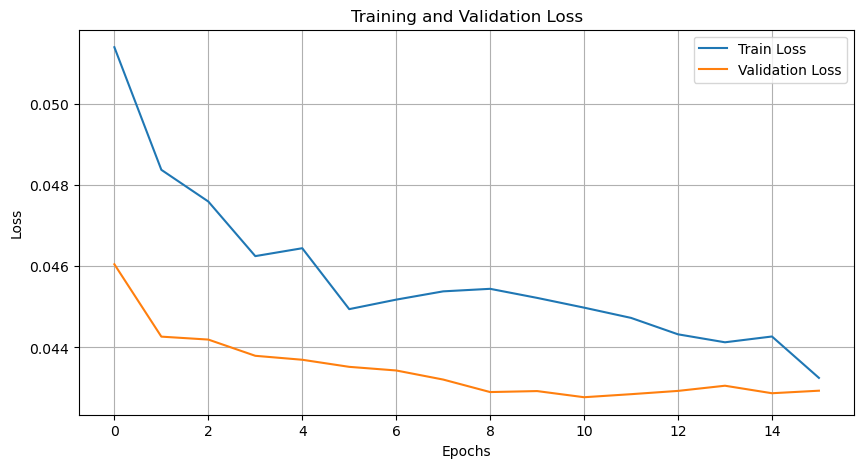

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
def full_evaluation(model, loader, threshold=0.5):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = torch.sigmoid(model(x)).cpu().numpy()
            all_probs.extend(outputs)
            all_labels.extend(y.numpy())
    
    y_true = np.array(all_labels).flatten()
    y_pred = (np.array(all_probs).flatten() > threshold)
    

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))  


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Vulnerable', 'Vulnerable'],
                yticklabels=['Non-Vulnerable', 'Vulnerable'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, all_probs)
    roc_auc = roc_auc_score(y_true, all_probs)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return roc_auc



Validation Set Evaluation:

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.73      0.66       641
         1.0       0.47      0.33      0.39       465

    accuracy                           0.56      1106
   macro avg       0.53      0.53      0.52      1106
weighted avg       0.54      0.56      0.54      1106



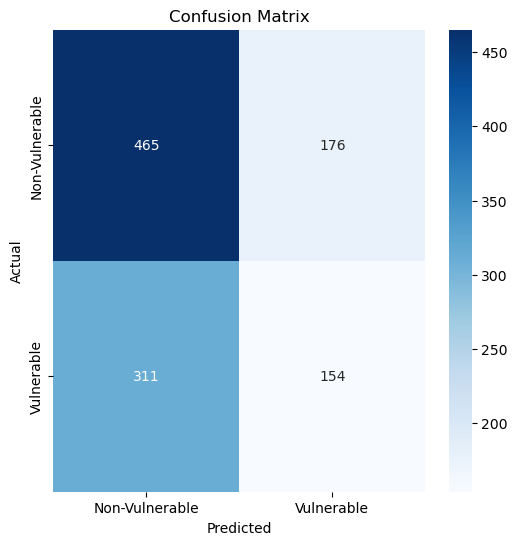

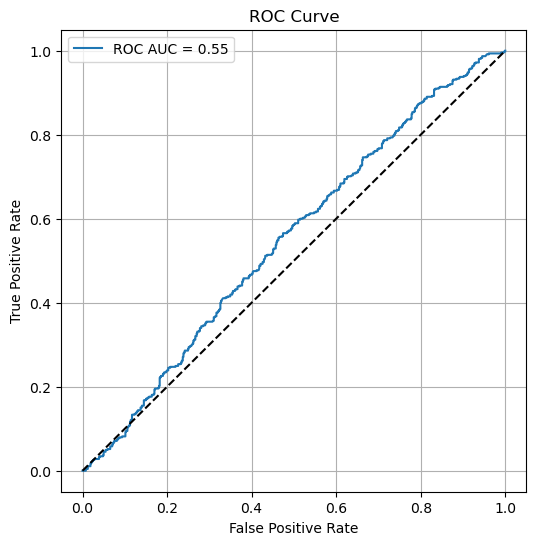


Test Set Evaluation:

Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.70      0.63       641
         1.0       0.42      0.30      0.35       466

    accuracy                           0.53      1107
   macro avg       0.50      0.50      0.49      1107
weighted avg       0.51      0.53      0.51      1107



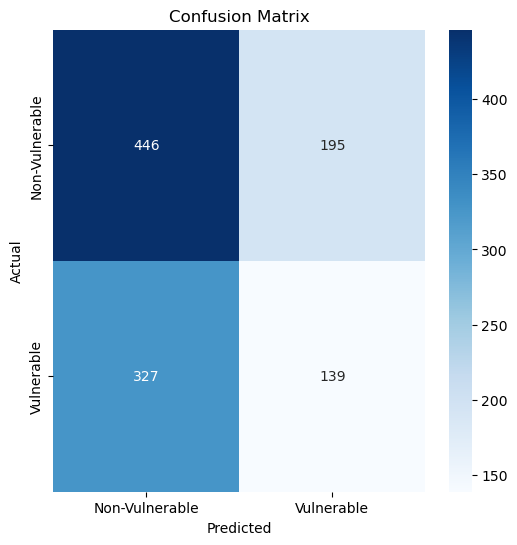

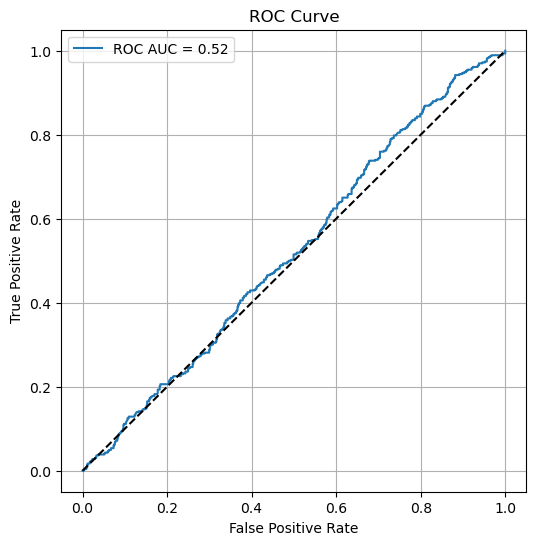

In [15]:
print("\nValidation Set Evaluation:")
val_auc = full_evaluation(model, val_loader)

print("\nTest Set Evaluation:")
test_auc = full_evaluation(model, test_loader)



Optimal Threshold: 0.4265

Test Set (with Optimal Threshold):

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.04      0.08       641
         1.0       0.43      0.98      0.60       466

    accuracy                           0.44      1107
   macro avg       0.60      0.51      0.34      1107
weighted avg       0.63      0.44      0.30      1107



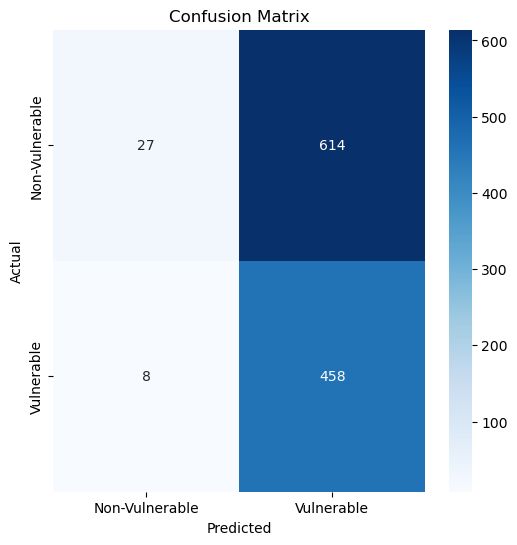

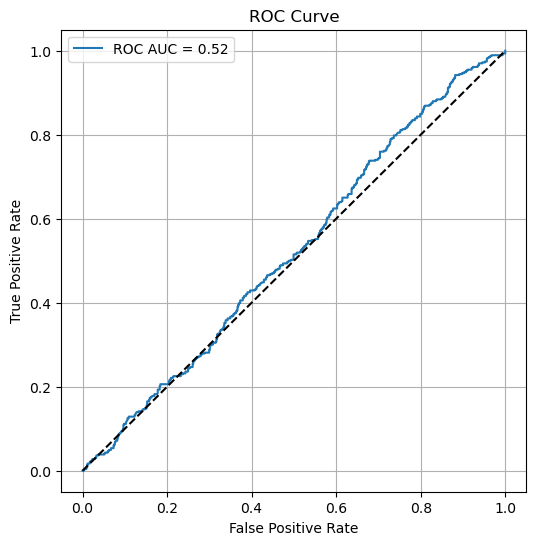

np.float64(0.5210323863598321)

In [16]:
def find_optimal_threshold(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = torch.sigmoid(model(x)).cpu().numpy()
            all_probs.extend(outputs)
            all_labels.extend(y.numpy())
    
    y_true = np.array(all_labels).flatten()
    probs = np.array(all_probs).flatten()
    
    thresholds = np.linspace(0.1, 0.9, 50)
    best_f1 = 0
    best_th = 0.5
    for th in thresholds:
        f1 = f1_score(y_true, probs > th, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_th = th
    return best_th

optimal_th = find_optimal_threshold(model, val_loader)
print(f"\nOptimal Threshold: {optimal_th:.4f}")

print("\nTest Set (with Optimal Threshold):")
full_evaluation(model, test_loader, threshold=optimal_th)


In [17]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_dim': embeddings.shape[1],
    'threshold': optimal_th
}, 'vulnerability_detector.pth')


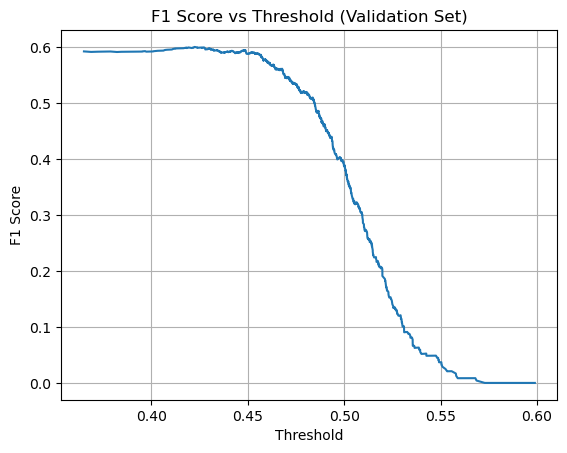

In [18]:
model.eval()
all_probs = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        outputs = torch.sigmoid(model(x)).cpu().numpy()
        all_probs.extend(outputs.flatten())

y_pred_probs = np.array(all_probs)
y_true = y_val.numpy() if isinstance(y_val, torch.Tensor) else np.array(y_val)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)


plt.plot(thresholds, f1_scores[:-1])
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold (Validation Set)")
plt.grid(True)
plt.show()
